✅ Percorso di training confermato: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Inizio analisi...
Numero Totale di Classi Trovate: 232

--- Prime 10 Classi per Frequenza ---
         Classe  Frequenza
0  Grape Blue 1        984
1    Cucumber 6        977
2   Cherimoya 1        972
3        Pear 9        928
4       Peach 3        927
5        Plum 3        900
6       Onion 2        765
7      Quince 4        750
8      Cherry 2        738
9      Tomato 3        738


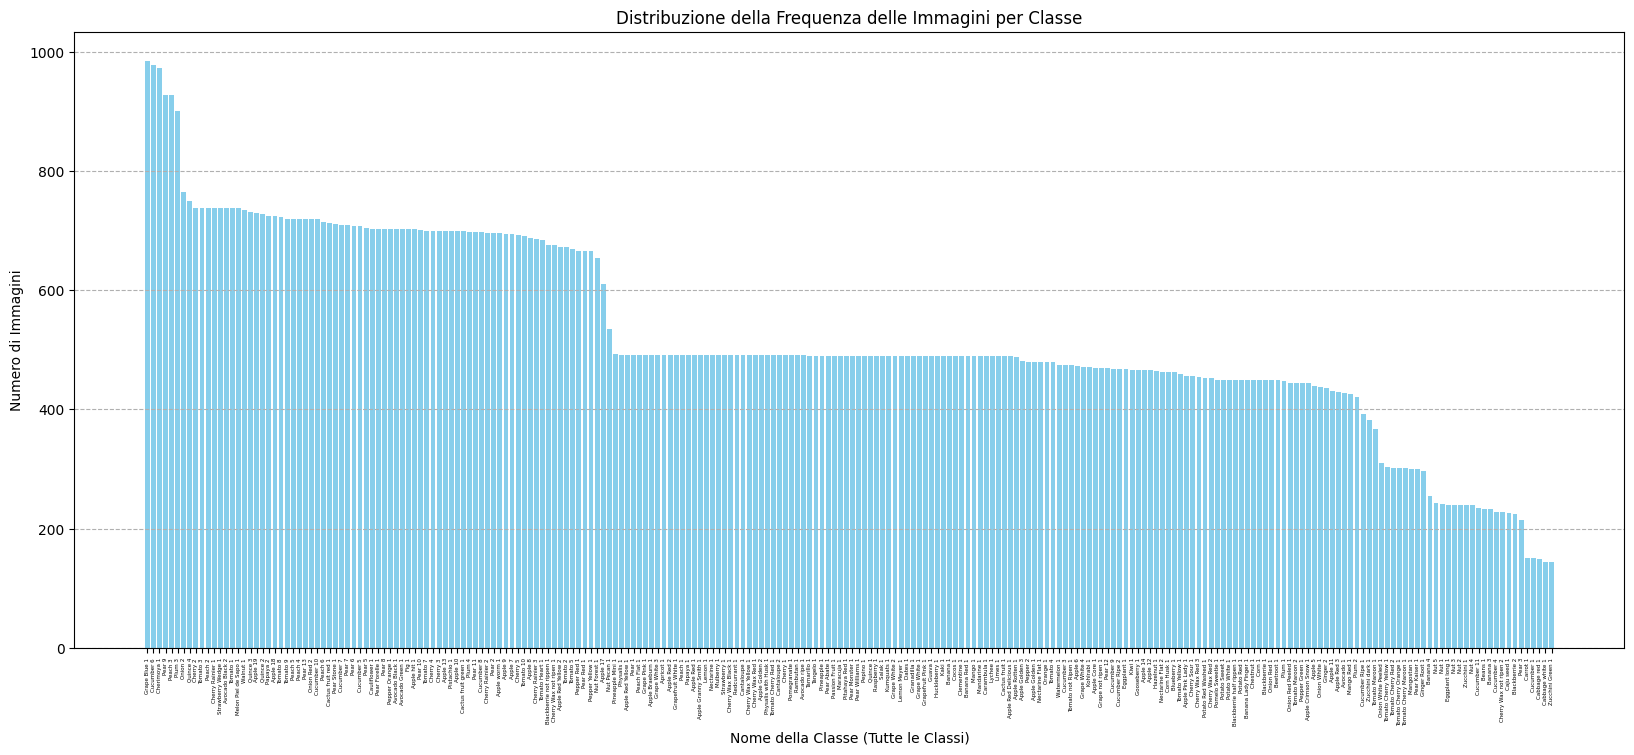


--- Analisi della Distribuzione (Uniformità) ---
Deviazione Standard (Varianza): 164.65

--- Visualizzazione delle 20 Classi Principali ---


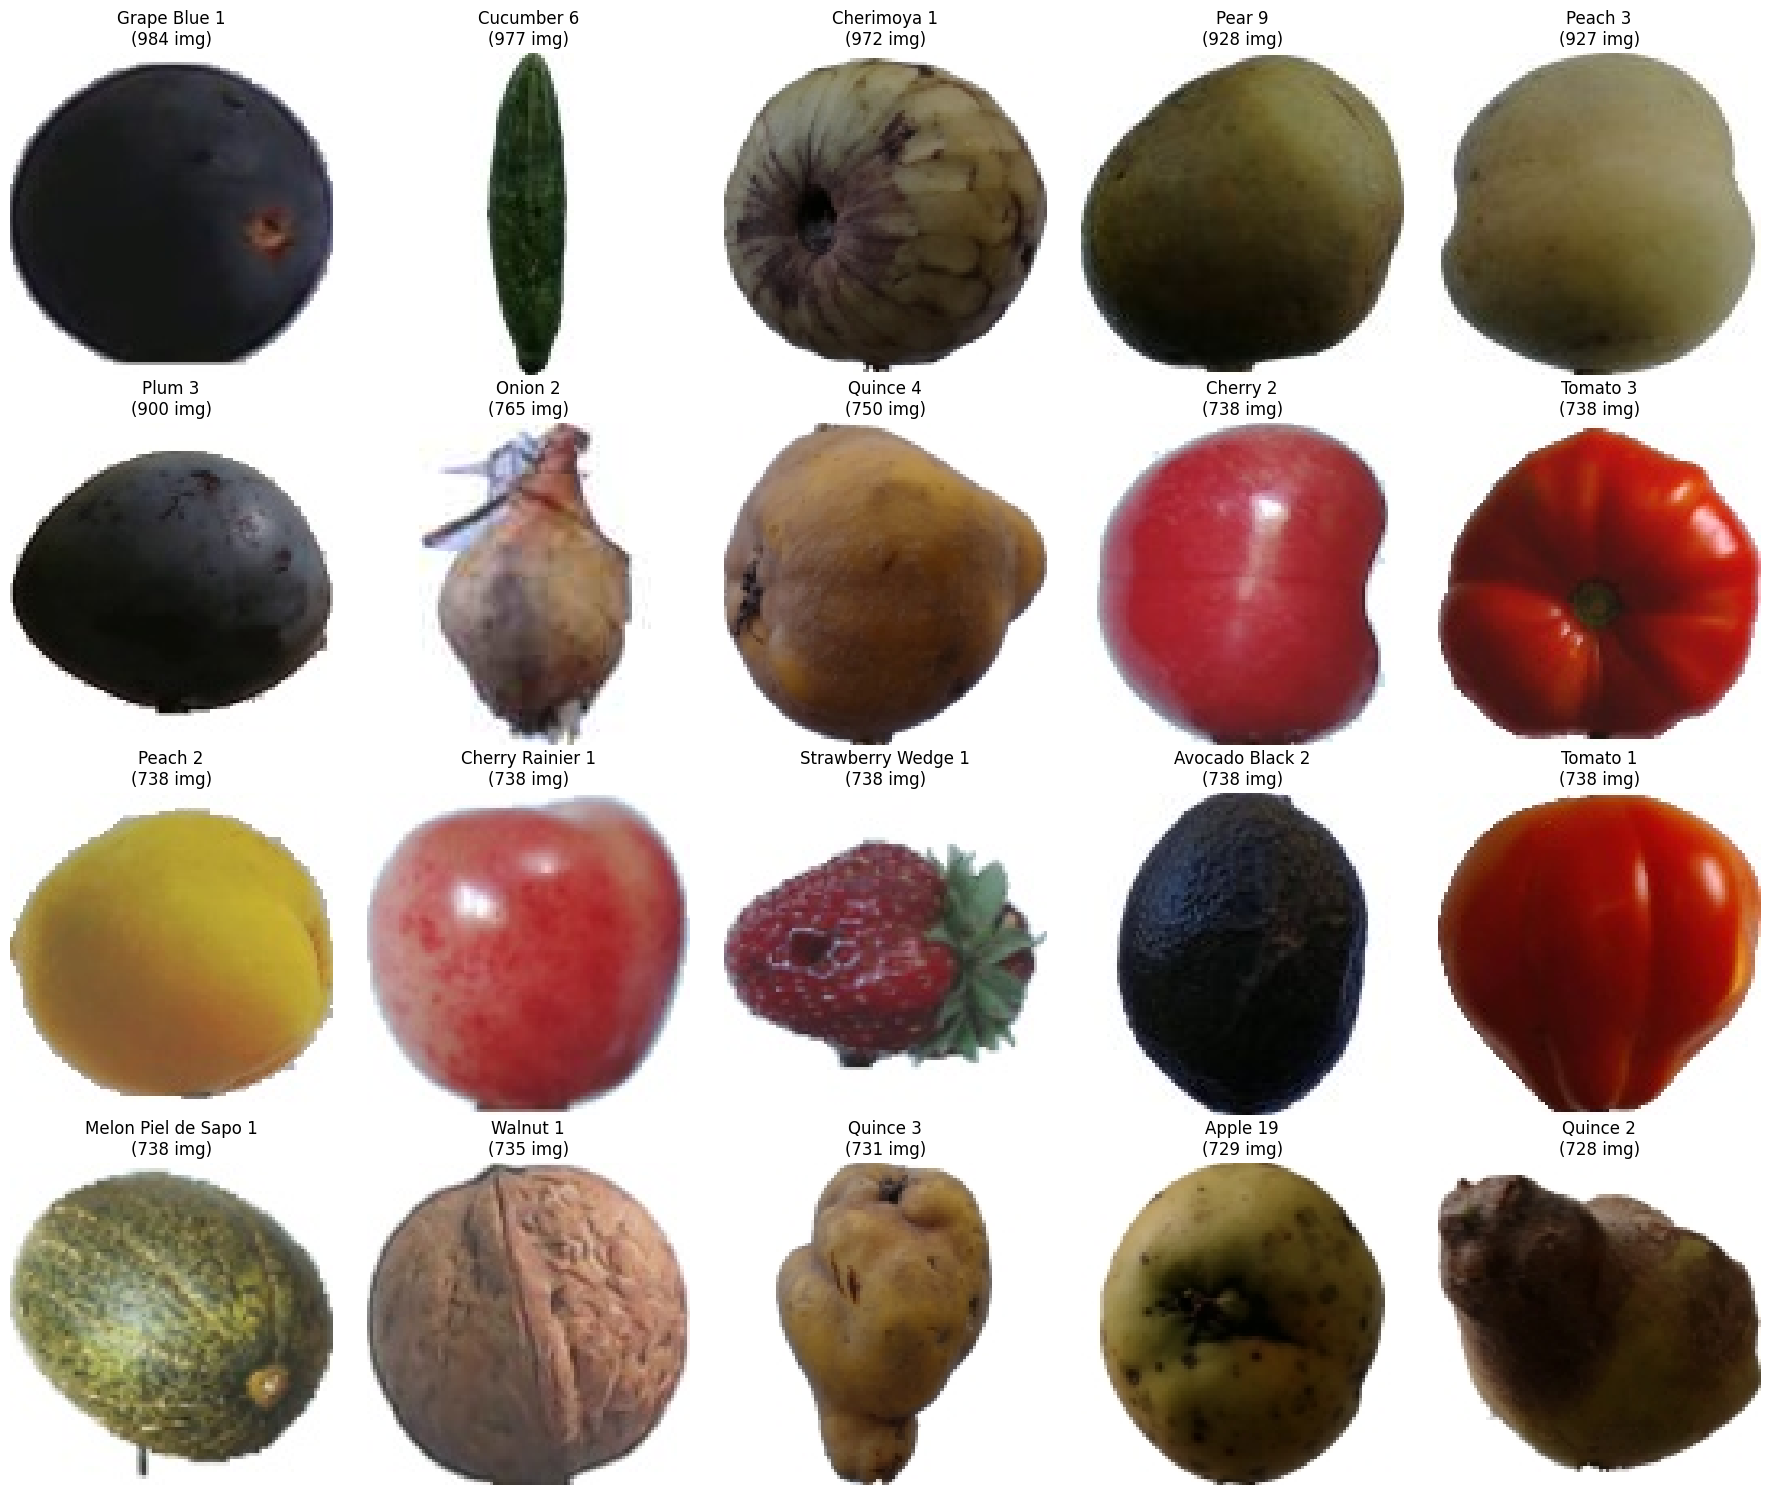

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

BASE_DIR = "/kaggle/input/fruits/fruits-360_100x100/fruits-360"
TRAIN_DIR = BASE_DIR + "/Training"
TEST_DIR = BASE_DIR + "/Test"

TRAIN_PATH = TRAIN_DIR 

if not os.path.exists(TRAIN_PATH):
    print(f"ERROR:training set not found: {TRAIN_PATH}")
    print("check BASE_DIR path.")

else:
    print(f" training path confirmed: {TRAIN_PATH}")
    print("start analysis...")


### 1. Classes and Frequencies Extraction
all_classes = sorted(os.listdir(TRAIN_PATH))
print(f"Total number of classes found: {len(all_classes)}")

# Dictiory 
class_counts = {}
for class_name in all_classes:
    class_path = os.path.join(TRAIN_PATH, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

df_counts = pd.DataFrame(
    list(class_counts.items()), 
    columns=['Classe', 'Frequenza']
).sort_values(by='Frequenza', ascending=False).reset_index(drop=True)

print("\n--- Prime 10 Classi per Frequenza ---")
print(df_counts.head(10))

plt.figure(figsize=(20, 8))
plt.bar(df_counts['Classe'], df_counts['Frequenza'], color='skyblue')
plt.title('Distribuzione della Frequenza delle Immagini per Classe')
plt.xlabel('Nome della Classe (Tutte le Classi)')
plt.ylabel('Numero di Immagini')
plt.xticks(rotation=90, fontsize=4) 
plt.grid(axis='y', linestyle='--')
plt.show()

print("\n--- Analisi della Distribuzione (Uniformità) ---")
std_dev = df_counts['Frequenza'].std()
print(f"Deviazione Standard (Varianza): {std_dev:.2f}")



TOP_N = 20
top_20_classes = df_counts.head(TOP_N)['Class'].tolist()
print(f"\n--- Visualization of {TOP_N} Principal Classes ---")

fig, axes = plt.subplots(4, 5, figsize=(18, 15)) 
axes = axes.flatten()

for i, class_name in enumerate(top_20_classes):
    class_path = os.path.join(TRAIN_PATH, class_name)
    
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if image_files:
        random_image_file = random.choice(image_files)
        random_image_path = os.path.join(class_path, random_image_file)
        
        try:
            img = Image.open(random_image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{class_name.replace(' ', ' ')}\n({class_counts[class_name]} img)")
            axes[i].axis('off') 
        except Exception:
            axes[i].set_title(f"Error loading: {class_name}")
            axes[i].axis('off')
            
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

BASE_DIR = "/kaggle/input/fruits/fruits-360_100x100/fruits-360"
TRAIN_DIR = BASE_DIR + "/Training"
TEST_DIR = BASE_DIR + "/Test"
IMG_SIZE = (100, 100)
BATCH_SIZE = 32 
PCA_VARIANCE_THRESHOLD = 0.95  # keep il 95% of variance
TOP_N_CLASSES = 20    # 20 main classes selection
L2_REG_RATE = 0.0005
EPOCHS = 30

def get_top_n_classes(directory, n):
    class_counts = {c: len(os.listdir(os.path.join(directory, c)))
                    for c in os.listdir(directory) if os.path.isdir(os.path.join(directory, c))}
    return sorted(class_counts, key=class_counts.get, reverse=True)[:n]

TOP_CLASSES = get_top_n_classes(TRAIN_DIR, TOP_N_CLASSES)
NUM_CLASSES = len(TOP_CLASSES)

print(f"Selected classes: {NUM_CLASSES}")

datagen = ImageDataGenerator(rescale=1./255)

n_train = datagen.flow_from_directory(TRAIN_DIR, class_mode=None).n
n_test = datagen.flow_from_directory(TEST_DIR, class_mode=None).n

train_generator_raw = datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=n_train,
    classes=TOP_CLASSES, class_mode='categorical', shuffle=False)

test_generator_raw = datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=n_test,
    classes=TOP_CLASSES, class_mode='categorical', shuffle=False)

X_train_original, y_train_original = train_generator_raw[0]
X_test_original, y_test_original = test_generator_raw[0]

# Flatten
X_train_flat = X_train_original.reshape(X_train_original.shape[0], -1)
X_test_flat = X_test_original.reshape(X_test_original.shape[0], -1)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# PCA
pca = PCA(n_components=PCA_VARIANCE_THRESHOLD)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Componenti PCA:", pca.n_components_)


Classi selezionate: 20
Found 122118 images belonging to 232 classes.
Found 40715 images belonging to 232 classes.
Found 16030 images belonging to 20 classes.
Found 5335 images belonging to 20 classes.
Componenti PCA: 503


In [23]:
import tensorflow as tf

class PCAAugmentor(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True,
                 noise_std=0.02, scale_range=0.05):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.noise_std = noise_std
        self.scale_range = scale_range
        self.indices = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = np.copy(self.X[batch_idx])
        y_batch = self.y[batch_idx]

        # augmentation PCA-space
        noise = np.random.normal(0, self.noise_std, X_batch.shape)
        scale = 1 + np.random.uniform(-self.scale_range, self.scale_range, X_batch.shape)
        X_batch = (X_batch + noise) * scale

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_gen_pca = PCAAugmentor(X_train_pca, y_train_original, batch_size=BATCH_SIZE)
test_gen_pca = PCAAugmentor(X_test_pca, y_test_original, batch_size=BATCH_SIZE,
                            noise_std=0.005, scale_range=0.01)



In [24]:
input_dim = X_train_pca.shape[1]
L2_REG_RATE = 0.0001
 
model_ffnn = Sequential([
    Dense(256, activation='relu', input_dim=input_dim, kernel_regularizer=l2(L2_REG_RATE)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(L2_REG_RATE)),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_ffnn.compile(optimizer=Adam(0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

model_ffnn.summary()

# ---------------------------
# TRAINING + EARLY STOPPING
# ---------------------------
early_stop = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True
)

history = model_ffnn.fit(
    train_gen_pca,
    validation_data=test_gen_pca,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

loss, acc = model_ffnn.evaluate(test_gen_pca, verbose=0)
print(f"\nAccuracy Finale Test: {acc*100:.2f}%")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       129,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,500 (642.58 KB)

 Trainable params: 164,500 (642.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6226 - loss: 2.6544 - val_accuracy: 0.9919 - val_loss: 0.2874
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9691 - loss: 0.1576 - val_accuracy: 0.9898 - val_loss: 0.3298
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9842 - loss: 0.1147 - val_accuracy: 0.9945 - val_loss: 0.3066
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9910 - loss: 0.0852 - val_accuracy: 0.9944 - val_loss: 0.2251
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9947 - loss: 0.0745 - val_accuracy: 0.9908 - val_loss: 0.2568
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9913 - loss: 0.0999 - val_accuracy: 0.9930 - val_loss: 0.1475
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9947 - loss: 0.0795 - val_accuracy: 0.9910 - val_loss: 0.1966
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9943 - loss: 0.0861 - val_accuracy: 0.

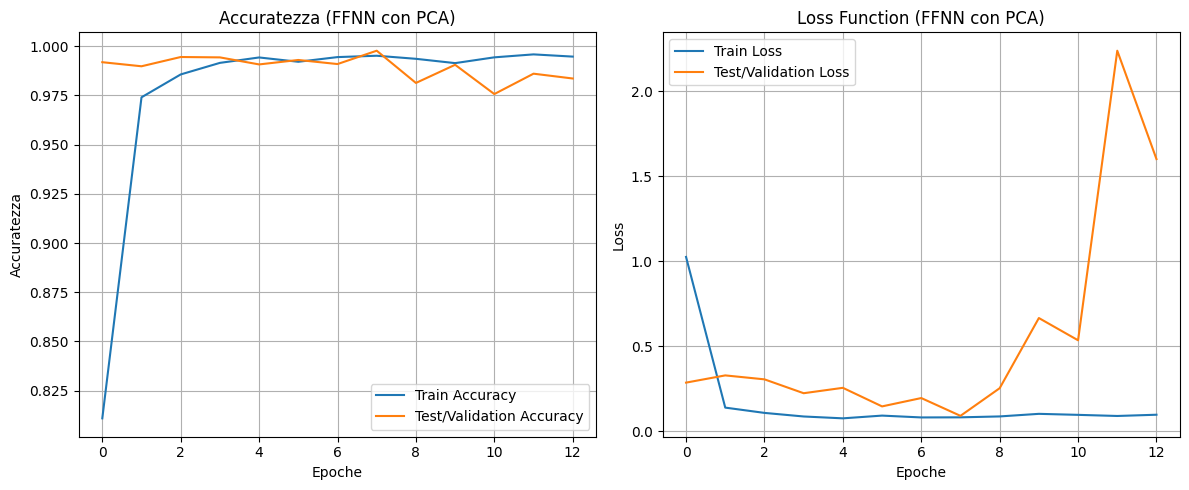

In [ ]:
# Plot(Train vs. Validation/Test)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test/Validation Accuracy')
plt.title('Accuratezza (FFNN con PCA)')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.legend()
plt.grid(True)


# Plot Loss (Train vs. Validation/Test)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test/Validation Loss')
plt.title('Loss Function (FFNN con PCA)')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


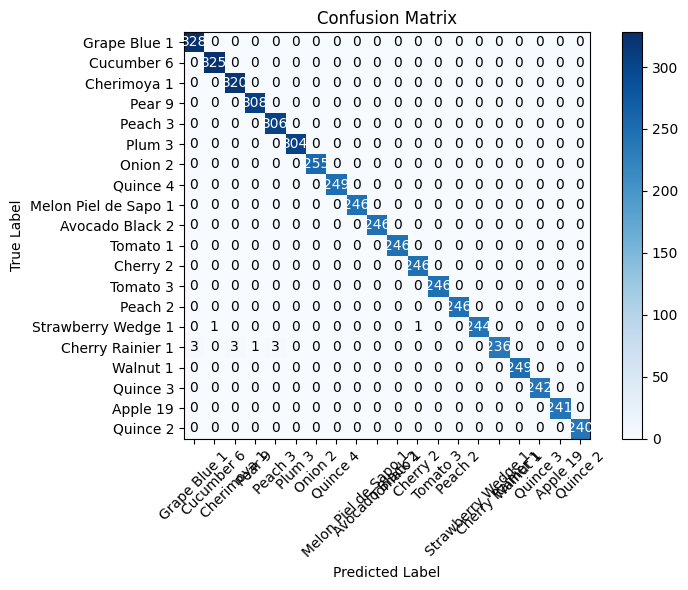


=== Classification Report ===
                      precision    recall  f1-score   support

        Grape Blue 1       0.99      1.00      1.00       328
          Cucumber 6       1.00      1.00      1.00       325
         Cherimoya 1       0.99      1.00      1.00       320
              Pear 9       1.00      1.00      1.00       308
             Peach 3       0.99      1.00      1.00       306
              Plum 3       1.00      1.00      1.00       304
             Onion 2       1.00      1.00      1.00       255
            Quince 4       1.00      1.00      1.00       249
Melon Piel de Sapo 1       1.00      1.00      1.00       246
     Avocado Black 2       1.00      1.00      1.00       246
            Tomato 1       1.00      1.00      1.00       246
            Cherry 2       1.00      1.00      1.00       246
            Tomato 3       1.00      1.00      1.00       246
             Peach 2       1.00      1.00      1.00       246
  Strawberry Wedge 1       1.00      0

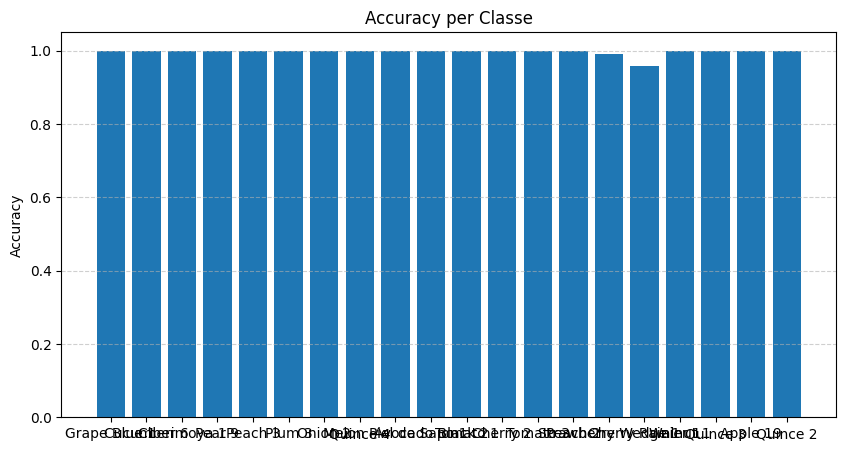

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------
# MODEL PREDICITON
# -------------------------
y_pred = model_ffnn.predict(X_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_original, axis=1)

# Class labels ordinate per indice
classes = [label_map[i] for i in range(len(label_map))]

# -------------------------
#   MATRICE DI CONFUSIONE
# -------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Numeri nelle celle
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# -------------------------
#   REPORT PER CLASS
# -------------------------
print("\n=== Classification Report ===")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# -------------------------
#   ACCURACY  (BAR CHART)
# -------------------------
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.bar(classes, per_class_accuracy)
plt.ylim(0, 1.05)
plt.title("Accuracy per Classe")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


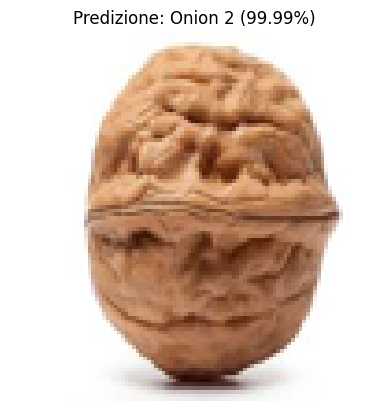

('Onion 2', 0.9998765)

In [ ]:
from PIL import Image

NEW_IMAGE_PATH ='/kaggle/input/test-2/wallnut.jpeg'

# map idx class 
label_map = {i: c for i, c in enumerate(TOP_CLASSES)}

def predict_new_image(image_path, model, scaler, pca, label_map, img_size):
    try:
        img = Image.open(image_path).resize(img_size)
        img_array = np.array(img) / 255.0  
        
        img_flat = img_array.reshape(1, -1)
        
        img_scaled = scaler.transform(img_flat)
        
        img_pca = pca.transform(img_scaled)
        
        prediction = model.predict(img_pca)
        predicted_index = np.argmax(prediction)
        predicted_class = label_map[predicted_index]
        confidence = prediction[0][predicted_index]
        
        plt.imshow(img_array)
        plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
        plt.axis('off')
        plt.show()
        
        return predicted_class, confidence
        
    except FileNotFoundError:
        print(f"ERROR: Image not found at {image_path}. Verify the path.")
    except Exception as e:
        print(f"Error during prediction: {e}")

predict_new_image(NEW_IMAGE_PATH, model_ffnn, scaler, pca, label_map, IMG_SIZE)

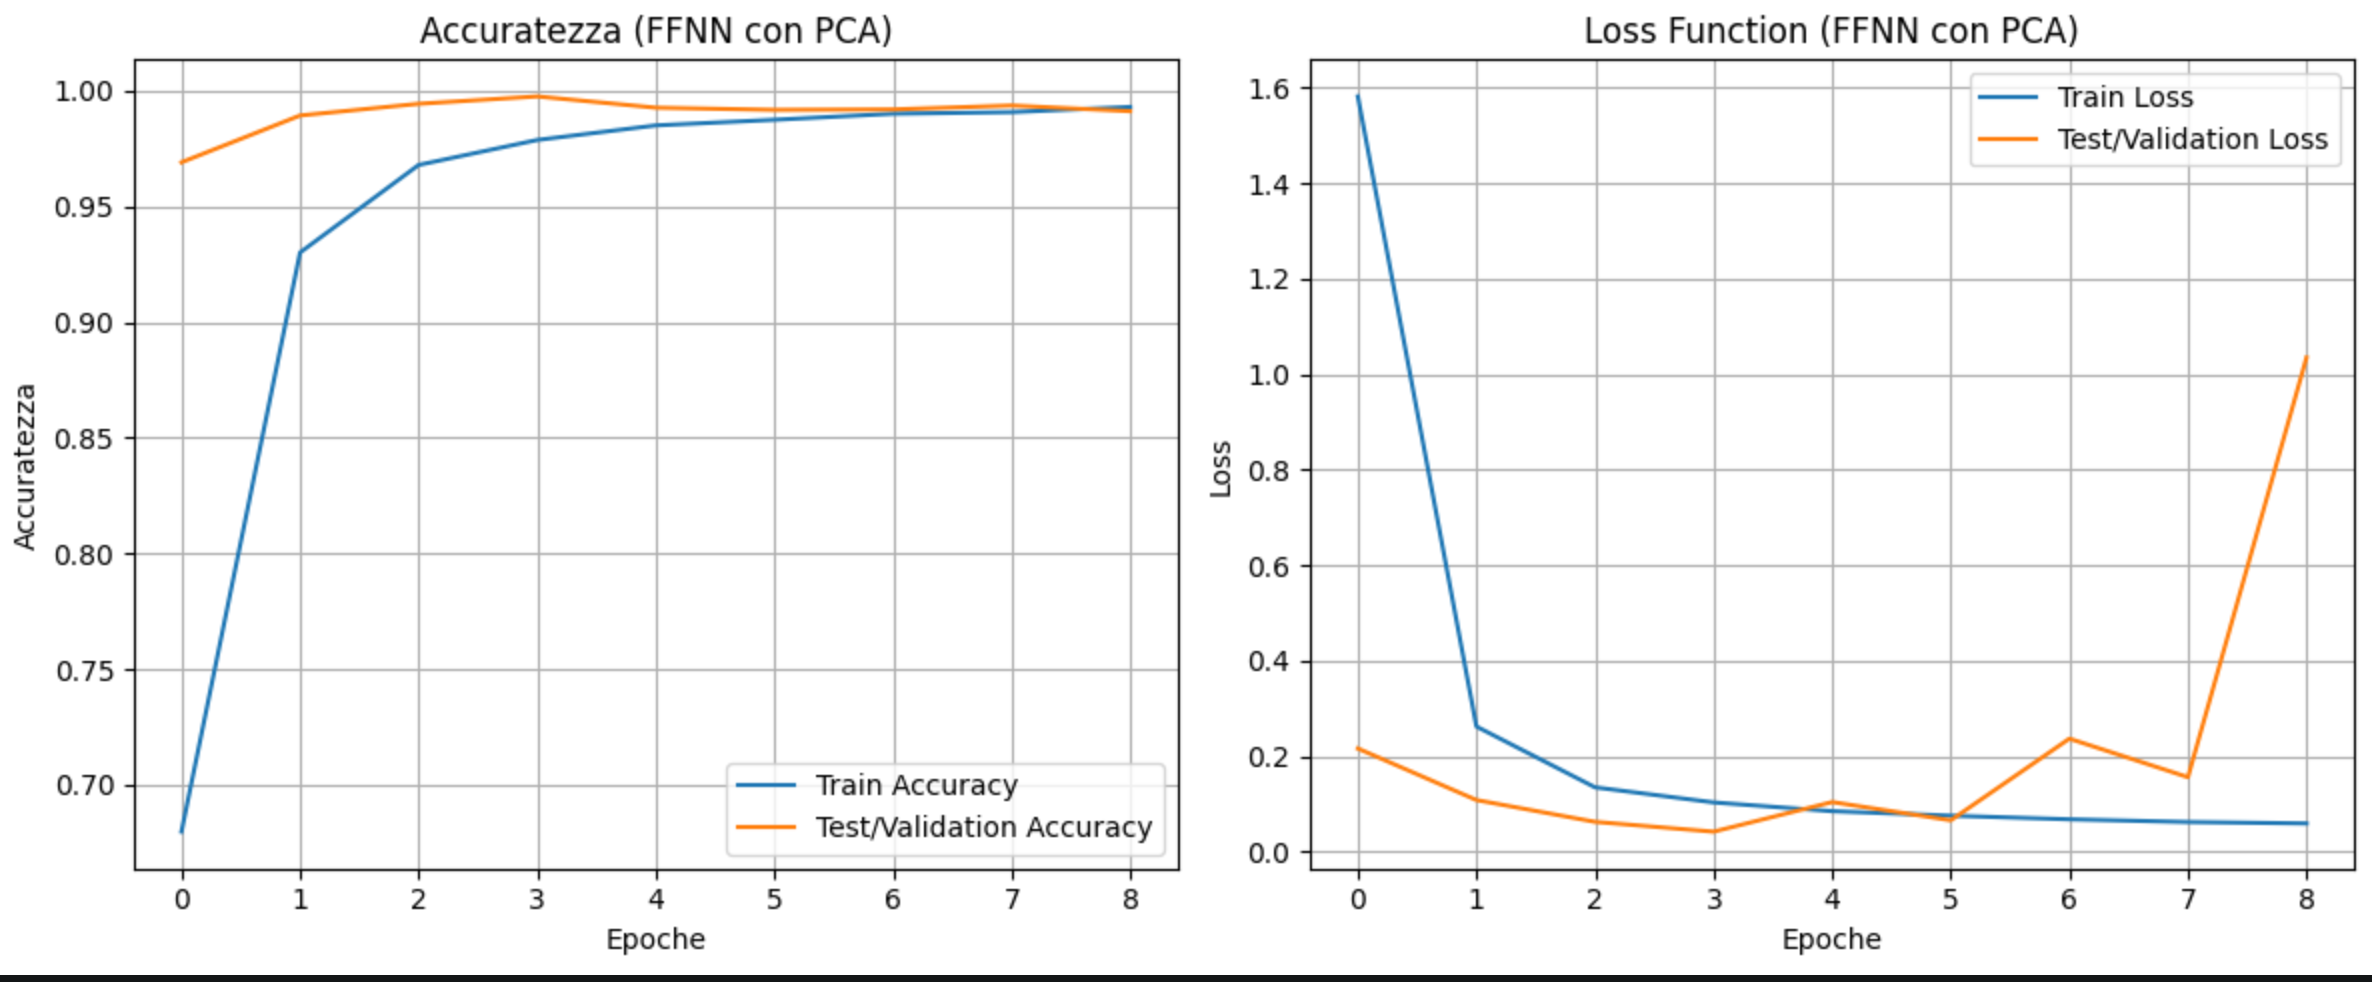

test 2: PCA_FFNN_l2_dropout.png


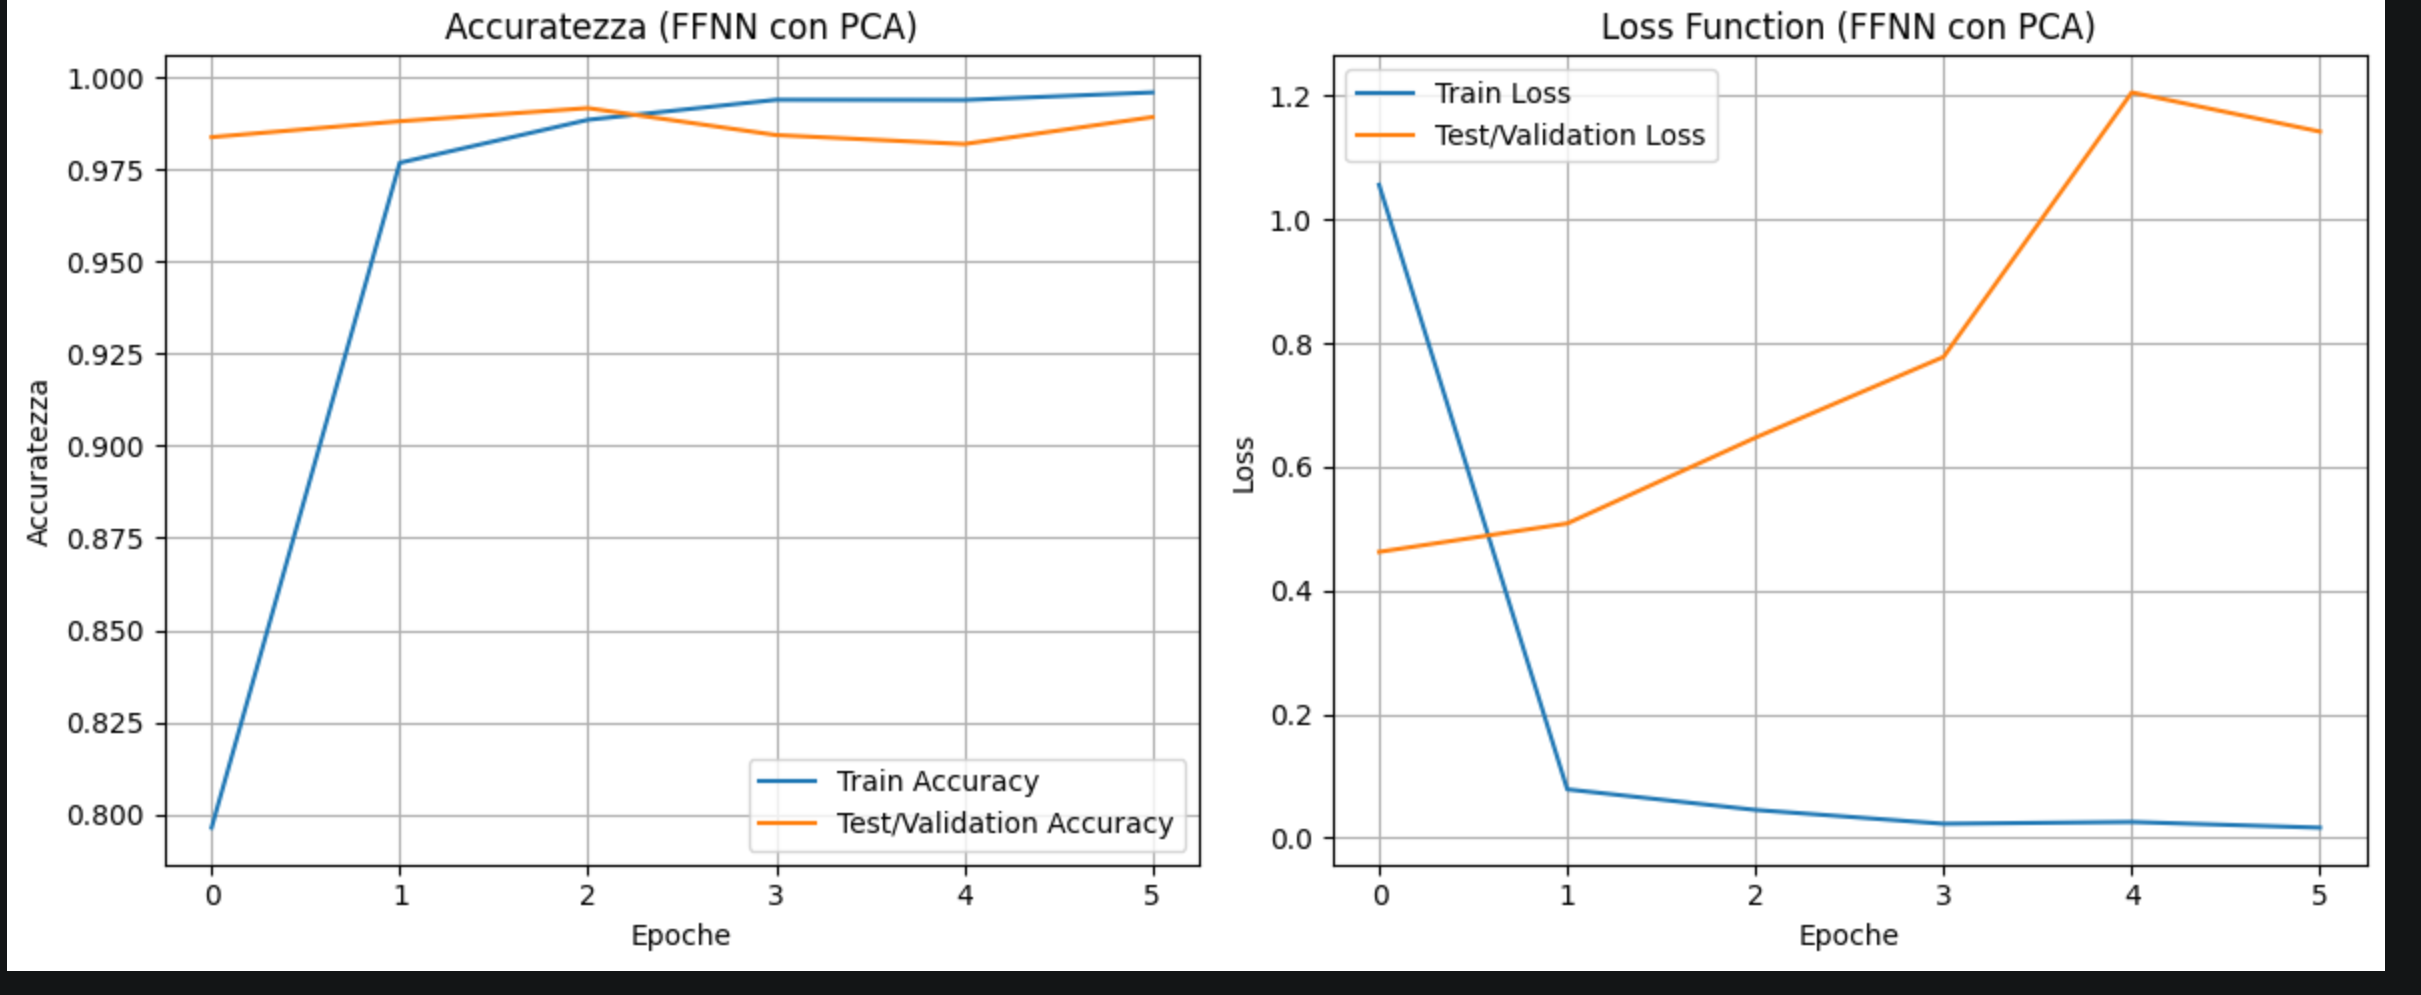

test 1: PCA_FFNN_0.png


In [3]:
from IPython.display import Image, display

nome_file = 'PCA_FFNN_l2_dropout.png'  
display(Image(filename=nome_file))
print ("test 2:", nome_file)

name_file = "PCA_FFNN_0.png"
display(Image(filename=name_file))
print ("test 1:", name_file)
